# Preprocess data

In [1]:
import csv
import cv2
import gzip
import matplotlib.pyplot as plt
import numpy as np
import os
import random

from datetime import datetime
from os.path import expanduser
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm_notebook

home_path = expanduser("~")

In [2]:
def data_generator(samples, shape, batch_size, correction, sensitivity, 
                   angle_threshold):
    num_samples = len(samples)
    rows, cols, ch = shape
    factors = [0, 1, -1]
    
    samples = shuffle(samples)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset + batch_size]

            X = []
            y = []
            for i, sample in enumerate(batch_samples):
                # get steering angle
                angle = float(line[4])
                
                # camera selection
                #  -> drop near-0 angle data with probability
                #  -> [0, 1, 2] = [center, left, right]
                if abs(angle) < angle_threshold and np.random.random() < 0.7:
                    camera = np.random.choice([1, 2])
                else:
                    camera = np.random.choice([0, 1, 2])
                
                adjustment = np.random.uniform(correction-sensitivity, 
                                                   correction+sensitivity)
                
                # adjust angle if needed
                # -> factors[0, 1, -1] = [center, left, right]
                angle += (factors[camera] * adjustment)

                # read image
                img_path = '../' + sample[camera]
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


                # randomly choose to flip
                if np.random.random() < 0.5:
                    img = np.fliplr(img)
                    angle *= -1
                
                # randomly amend brightness
                # https://discussions.udacity.com/t/still-having-some-issues-with-project-behavioral-cloning-any-advice/234354/45
                if np.random.random() < 0.5:
                    random_bright = .25 + np.random.uniform()
                    
                    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
                    img[:,:,2] = img[:,:,2] * random_bright
                    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
                    img = np.clip(img, 0, 255)
                
                X.append(img)
                y.append(angle)

            yield shuffle(np.array(X), np.array(y))

In [3]:
# read in driving log
samples = []
with open('../data/interim/img/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

# drop header
samples = samples[1:-1]

# allow the samples list to be looped through multiple times
# due to randomness in the generator, different images should be
# seen when the same row is looked at again
samples *= 2

epochs to test generator: 1607
x shape = (10, 160, 320, 3)
y shape = (10,)
[-0.2 -0.2 -0.  -0.2  0.2 -0.  -0.2 -0.2 -0.2  0.2]
-0.2


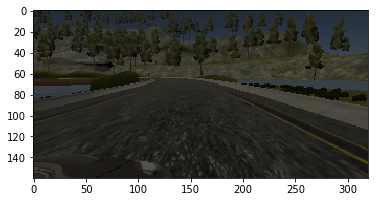



16070


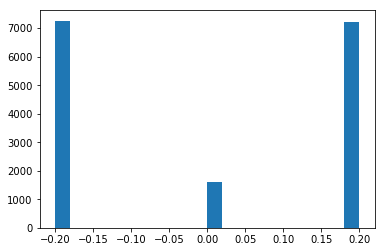

CPU times: user 33.1 s, sys: 1.43 s, total: 34.5 s
Wall time: 33.6 s


In [6]:
def test_gen():
    test_gen_batch_size = 10
    test_gen_samples = len(samples)
    test_gen_epochs = test_gen_samples // test_gen_batch_size
    print('epochs to test generator: {}'.format(test_gen_epochs))
    
    test_generator = data_generator(
        samples, 
        shape=(160,320,3), 
        batch_size=test_gen_batch_size, 
        correction=0.2,
        sensitivity=0.0,
        angle_threshold=0.85)

    angles = []
    for i in tqdm_notebook(range(test_gen_epochs)):
        X_gen_batch, y_gen_batch = next(test_generator)

        # ensure images are coming through properly
        if i == 1:
            print('x shape = {}\ny shape = {}'.format(X_gen_batch.shape, y_gen_batch.shape))
            print(y_gen_batch)
            print(y_gen_batch[0])
            plt.imshow(X_gen_batch[0])
            plt.show()

        # keep angles, will review in histogram to see distribution
        angles.extend(y_gen_batch)
    
    print(len(angles))
    plt.hist(angles, bins=20)
    plt.show()
    
    
%time test_gen()

# Keras modelling

In [7]:
import itertools

from contextlib import redirect_stdout

from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers import (
    Lambda, Cropping2D, Flatten, Dense, 
    SpatialDropout2D, )
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import AveragePooling2D, MaxPooling2D
from keras.models import Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


In [8]:
def build_model(input_shape, dropout):
    # model architecture based on
    # -> https://arxiv.org/pdf/1604.07316.pdf
    model = Sequential()

    # region of interest
    # Cropping2D((pixels_to_remove_from_top, from_bottom), (0, 0))
    model.add(Cropping2D(cropping=((60, 20), (0, 0)), input_shape=input_shape))
    
    # resize using average pooling
    # Keras 1.2.1 stride defaults to pool_size when no args are provided
    model.add(AveragePooling2D(pool_size=(2, 2)))

    # normalisation
    model.add(Lambda(lambda x: x / 255.0 - 0.5))

    # Convolution2D(filters, kernel, stride)
    model.add(Convolution2D(6, 5, 5, subsample=(2, 2), activation='relu', name='conv_1'))
    model.add(Convolution2D(12, 5, 5, subsample=(2, 2), activation='relu', name='conv_2'))
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='relu', name='conv_3'))
    model.add(SpatialDropout2D(dropout))

    # flatten
    model.add(Flatten(name='flatten'))

    # fully connected
    model.add(Dense(100, name='fc_1'))
    model.add(Dense(50, name='fc_2'))
    model.add(Dense(10, name='fc_3'))

    # output
    model.add(Dense(1, name='output'))

    # get model ready to run
    model.compile(optimizer=Adam(lr=1e-04), loss='mean_squared_error')
    
    return model

In [9]:
# model hyper-parameters
epochs = [10,]
batch_sizes = [10,]
dropout = [0.1,]

# camera hyper-parameters
corrections = [0.25,]
sensitivity = [0,]
angle_threshold = [0.85, ]

# set known image attributes
input_shape = (160, 320, 3)

# build grid
hyperparameters = [epochs, batch_sizes, dropout, corrections, sensitivity, angle_threshold]
grid = list(itertools.product(*hyperparameters))

# debug
print('grid space: {}'.format(len(grid)))
print('epochs: {}'.format(epochs))
print('batch_sizes: {}'.format(batch_sizes))
print('dropout: {}'.format(dropout))
print('corrections: {}'.format(corrections))
print('sensitivity: {}'.format(sensitivity))
print('angle_threshold: {}'.format(angle_threshold))


grid space: 1
epochs: [10]
batch_sizes: [10]
dropout: [0.1]
corrections: [0.25]
sensitivity: [0]
angle_threshold: [0.85]


In [12]:
# perform grid search if multiple choices exist for hyperparameters
for hyperparameters in grid:
    # set hyperparameters
    epochs = hyperparameters[0]
    batch_size = hyperparameters[1]
    dropout = hyperparameters[2]
    correction = hyperparameters[3]
    sensitivity = hyperparameters[4]
    angle_threshold = hyperparameters[5]
    
    # build model
    model = build_model(input_shape, dropout)

    # set train and validate sets
    train_samples, validation_samples = train_test_split(samples, test_size=0.3)

    # set generator functions
    train_generator = data_generator(
        train_samples, 
        shape=input_shape, 
        batch_size=batch_size,
        correction=correction,
        sensitivity=sensitivity,
        angle_threshold=angle_threshold)

    validation_generator = data_generator(
        validation_samples,
        shape=input_shape,
        batch_size=batch_size,
        correction=correction,
        sensitivity=sensitivity,
        angle_threshold=angle_threshold)

    # create directories for logging and checkpointing
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run = '_'.join([str(h).replace('.','') for h in hyperparameters])
    log_dir = os.path.join(home_path, 
                           'repos', 
                           'udacity_carnd', 
                           'project_3', 
                           'log', 
                           '_'.join([timestamp, run]))
    model_dir = os.path.join(home_path, 
                             'repos', 
                             'udacity_carnd', 
                             'project_3', 
                             'model', 
                             '_'.join([timestamp, run]))
    
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
        print(log_dir)

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
        print(model_dir)

    # get callbacks ready to run
    chk = ModelCheckpoint(
        filepath=os.path.join(model_dir, 'model_{epoch:02d}_{val_loss:.4f}.h5'),
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False, 
        mode='auto', 
        period=1)
    
    callbacks = [chk]

    # train the model
    history_object = model.fit_generator(
        train_generator,
        samples_per_epoch=len(train_samples),
        validation_data=validation_generator,
        nb_val_samples=len(validation_samples),
        nb_epoch=epochs,
        verbose=1,
        callbacks=callbacks)

    # save final epoch, as checkpoint callback won't
    final_model_name = '_'.join(['model', 
                                 '{:02d}'.format(epochs), 
                                 '{:.4f}'.format(history_object.history['val_loss'][-1])]) + '.h5'
    final_model_path = os.path.join(model_dir, final_model_name)
    model.save(final_model_path)

    # plot the training and validation loss for each epoch
    f, ax = plt.subplots(figsize=(8, 3))
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    f.tight_layout()

    # save plot
    f.savefig(os.path.join(model_dir, 'epoch_history.png'))
                                    
    # save model.summary()
    # https://stackoverflow.com/a/40984270/893766
    with open(os.path.join(model_dir, 'model_summary.txt'), 'w') as f:
        with redirect_stdout(f):
            model.summary()


/home/carnd/repos/udacity_carnd/project_3/log/20170529_125223_10_10_01_025_0_085
/home/carnd/repos/udacity_carnd/project_3/model/20170529_125223_10_10_01_025_0_085
Epoch 1/10
11249/11249 [==============================] - 39s - loss: 0.0302 - val_loss: 0.0251
Epoch 2/10
11249/11249 [==============================] - 39s - loss: 0.0224 - val_loss: 0.0212
Epoch 3/10
11249/11249 [==============================] - 39s - loss: 0.0209 - val_loss: 0.0200
Epoch 4/10
11249/11249 [==============================] - 39s - loss: 0.0202 - val_loss: 0.0194
Epoch 5/10
11249/11249 [==============================] - 39s - loss: 0.0193 - val_loss: 0.0179s: 0
Epoch 6/10
11249/11249 [==============================] - 39s - loss: 0.0183 - val_loss: 0.0186
Epoch 7/10
11249/11249 [==============================] - 39s - loss: 0.0181 - val_loss: 0.0176
Epoch 8/10
11249/11249 [==============================] - 39s - loss: 0.0176 - val_loss: 0.0179
Epoch 9/10
11249/11249 [==============================] - 39s - 